In [1]:
########### LIBRARIES ##########
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
from matplotlib import rcParams
%pylab inline

rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [7, 6]

from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

from sklearn.preprocessing import MinMaxScaler

import os
from scipy.io import loadmat,savemat

Populating the interactive namespace from numpy and matplotlib


C:\Users\paolo\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['fft']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
save = False
train = False

seed = 10

### Load the data
You must run *ReactionDiffusion.ipynb* in order to generate the dataset

In [3]:
data = loadmat('reaction_diffusion_big.mat')
t = data['t'][:,0]
x = data['x'][0,:]
y = data['y'][0,:]
U = data['u']
V = data['v']

n = len(x) # also the length of y
steps = len(t)
dx = x[2]-x[1]
dy = y[2]-y[1]
dt = t[2]-t[1]

#### Test at time T = 6

In [4]:
t_test = 150

C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/2841511970.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(xx,yy,U[:,:,t_test],cmap='viridis')
C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/2841511970.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(xx,yy,V[:,:,t_test],cmap='viridis')


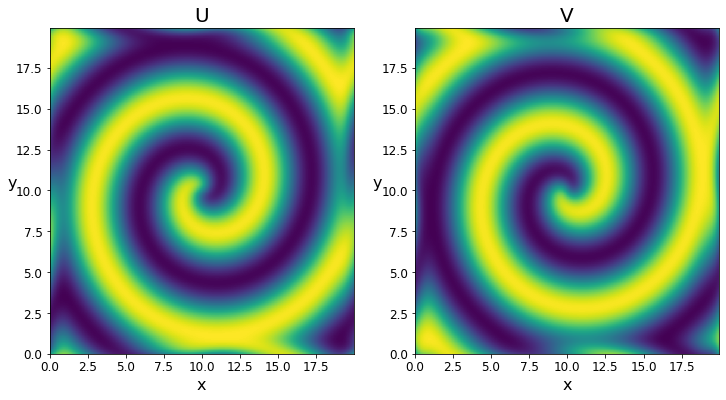

In [5]:
#Plot
pylab.rcParams['figure.figsize'] = (12, 6)
figure()
xx, yy = meshgrid(
    np.arange(n)*dx,
    np.arange(n)*dy)
subplot(1,2,1)
pcolor(xx,yy,U[:,:,t_test],cmap='viridis')
title('U', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16, rotation = 0)

subplot(1,2,2)
pcolor(xx,yy,V[:,:,t_test],cmap='viridis')
title('V', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16, rotation = 0)
pylab.rcParams['figure.figsize'] = (12, 8)

## Project data into a lower-dimensional subspace through SVD

In [6]:
U_ = U.reshape(n**2,steps)
V_ = V.reshape(n**2,steps)

In [7]:
u_u_svd, u_s_svd, u_v_svd = np.linalg.svd(U_, full_matrices = False)
v_u_svd ,v_s_svd, v_v_svd = np.linalg.svd(V_, full_matrices = False)

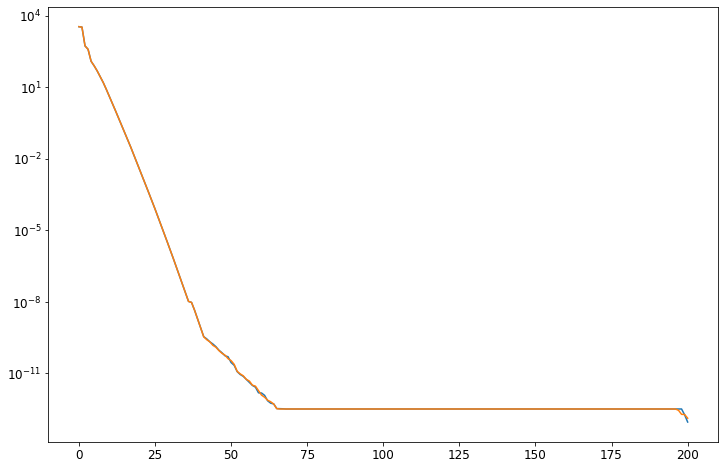

In [8]:
semilogy(u_s_svd)
semilogy(v_s_svd)

We consider the first 64 modes both for **U** and **V**

In [9]:
n_svd = 64
u_u_svd = u_u_svd[:,:n_svd]
v_u_svd = v_u_svd[:,:n_svd]

C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/684341072.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(xx,yy,u_u_svd_plot[:,:,0],cmap='inferno')
C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/684341072.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolor(xx,yy,u_u_svd_plot[:,:,1],cmap='inferno')
C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/684341072.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same di

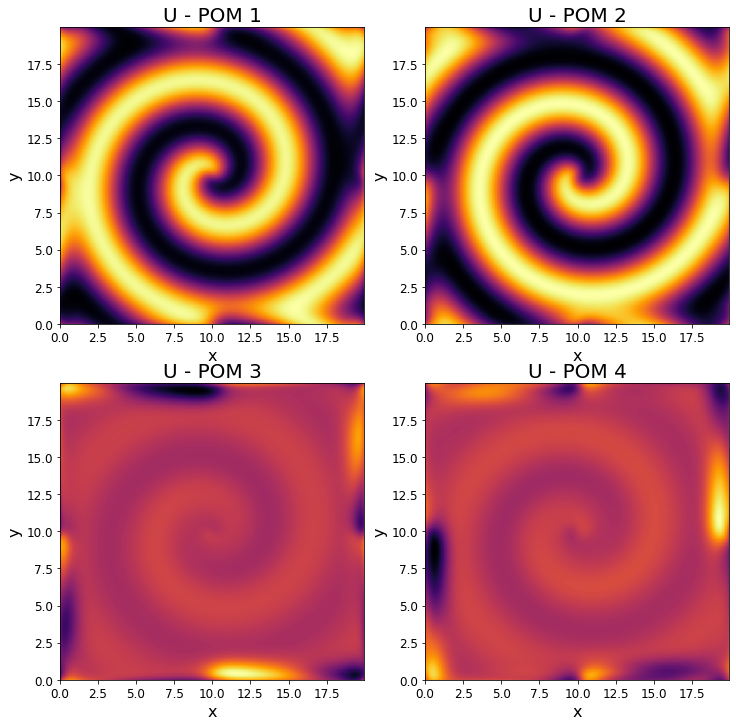

In [10]:
#Plot the first 4 spatial modes of U
u_u_svd_plot = u_u_svd.reshape(n,n,-1)

pylab.rcParams['figure.figsize'] = (12, 12)
figure()
xx, yy = meshgrid(
    np.arange(n)*dx,
    np.arange(n)*dy)
subplot(2,2,1)
pcolor(xx,yy,u_u_svd_plot[:,:,0],cmap='inferno')
title('U - POM 1', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(2,2,2)
pcolor(xx,yy,u_u_svd_plot[:,:,1],cmap='inferno')
title('U - POM 2', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (12, 8)
subplot(2,2,3)
pcolor(xx,yy,u_u_svd_plot[:,:,2],cmap='inferno')
title('U - POM 3', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(2,2,4)
pcolor(xx,yy,u_u_svd_plot[:,:,3],cmap='inferno')
title('U - POM 4', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (12, 8)

In [11]:
U_reduced = np.matmul(np.transpose(u_u_svd), U_)
V_reduced = np.matmul(np.transpose(v_u_svd), V_)

In [12]:
'''
#Check POD reconstruction
U_reconstructed = np.matmul(u_u_svd, U_reduced).reshape(n,n,-1)

pylab.rcParams['figure.figsize'] = (12, 6)
figure()
xx, yy = meshgrid(
    np.arange(n)*dx,
    np.arange(n)*dy)
subplot(1,2,1)
pcolor(xx,yy,U[:,:,t_test],cmap='coolwarm',vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))
title('U', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(1,2,2)
pcolor(xx,yy,U_reconstructed[:,:,t_test],cmap='coolwarm',vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))
title('U reconstructed', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (12, 8)'''

"\n#Check POD reconstruction\nU_reconstructed = np.matmul(u_u_svd, U_reduced).reshape(n,n,-1)\n\npylab.rcParams['figure.figsize'] = (12, 6)\nfigure()\nxx, yy = meshgrid(\n    np.arange(n)*dx,\n    np.arange(n)*dy)\nsubplot(1,2,1)\npcolor(xx,yy,U[:,:,t_test],cmap='coolwarm',vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))\ntitle('U', fontsize = 20)\nxlabel('x', fontsize = 16)\nylabel('y', fontsize = 16)\nsubplot(1,2,2)\npcolor(xx,yy,U_reconstructed[:,:,t_test],cmap='coolwarm',vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))\ntitle('U reconstructed', fontsize = 20)\nxlabel('x', fontsize = 16)\nylabel('y', fontsize = 16)\npylab.rcParams['figure.figsize'] = (12, 8)"

### Builid and train the NN model

In [13]:
#Prepare data to feed the NN
nn_data = np.concatenate((U_reduced, V_reduced))
nn_input = nn_data[:,:-1].T
nn_output = nn_data[:,1:].T

scaler = MinMaxScaler()
nn_input = scaler.fit_transform(nn_input)
nn_output = scaler.transform(nn_output)

In [14]:
# Set seed for reproducibility
np.random.seed(seed)
x_train, x_valid, y_train, y_valid = train_test_split(nn_input, nn_output, test_size = 0.1)

# Build model
nn_model = keras.models.Sequential()
nn_model.add(layers.Dense(128, input_dim=128, activation='tanh',))
nn_model.add(layers.Dense(64, activation='tanh'))
nn_model.add(layers.Dense(64, activation='tanh'))
nn_model.add(layers.Dense(128, activation='linear'))

# Compile model
opt = keras.optimizers.Adam(learning_rate=2e-3)
nn_model.compile(loss='mse', optimizer=opt)

# Fit!
if train:
    tf.random.set_seed(seed)
    History = nn_model.fit(x_train, y_train, epochs=1000, batch_size=10, validation_data=(x_valid, y_valid), callbacks=keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=50, restore_best_weights= True))
else:
    # load json and create model
    json_file = open('./models/nn_RD.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn_model = model_from_json(loaded_model_json)
    # load weights into new model
    nn_model.load_weights("./models/nn_RD.h5")
    print("Loaded model from disk")

if save:
    # serialize model to JSON
    model_json = nn_model.to_json()
    with open("./models/nn_RD", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    nn_model.save_weights("./models/nn_RD.h5")
    print("Saved model to disk")

Loaded model from disk


## Approach I: Advance solution from $t$ to $t + \Delta t$

In [15]:
u_pred = nn_model.predict(nn_input)

u_pred = scaler.inverse_transform(u_pred)
nn_output = scaler.inverse_transform(nn_output)
print('mse: ', np.mean(np.square(u_pred - nn_output)))

mse:  29.846213407354952


#### Reconstruct physical solution

In [16]:
u_pred_full = np.matmul(u_u_svd, np.transpose(u_pred[:,:n_svd])).reshape(n,n,-1)
v_pred_full = np.matmul(v_u_svd, np.transpose(u_pred[:,n_svd:])).reshape(n,n,-1)

C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/3539609133.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = pcolor(xx,yy,U[:,:,t_test],cmap='viridis', vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))
C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/3539609133.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = pcolor(xx,yy,u_pred_full[:,:,t_test+1],cmap='viridis', vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))
C:\Users\

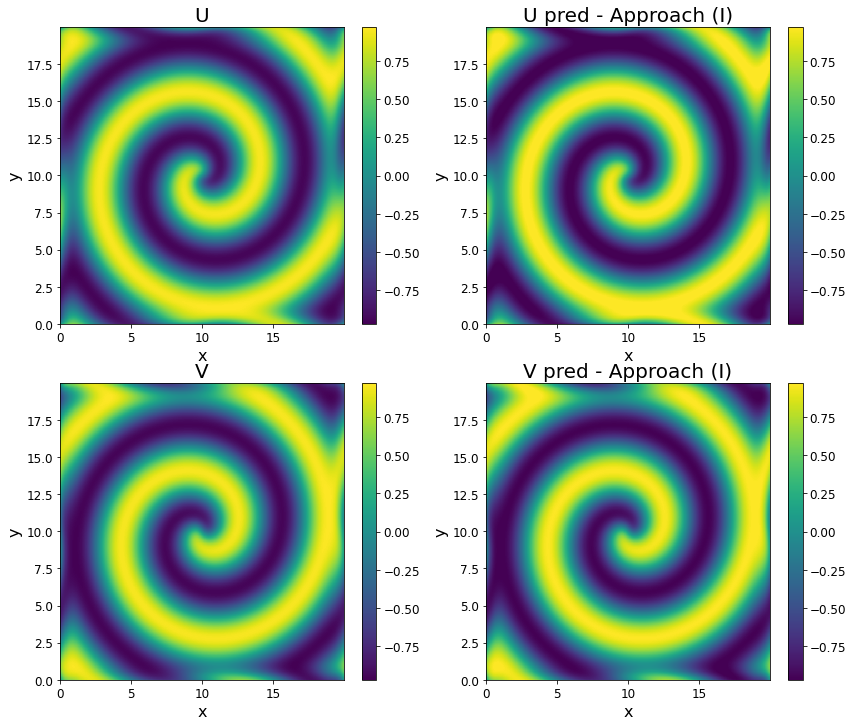

In [17]:
pylab.rcParams['figure.figsize'] = (14, 12)
figure()
xx, yy = meshgrid(
    np.arange(n)*dx,
    np.arange(n)*dy)
subplot(2,2,1)
im = pcolor(xx,yy,U[:,:,t_test],cmap='viridis', vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))
colorbar(im)
title('U', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(2,2,2)
im = pcolor(xx,yy,u_pred_full[:,:,t_test+1],cmap='viridis', vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))
colorbar(im)
title('U pred - Approach (I)', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (12, 8)

subplot(2,2,3)
im = pcolor(xx,yy,V[:,:,t_test],cmap='viridis',vmin = np.min(V[:,:,t_test]), vmax = np.max(V[:,:,t_test]))
colorbar(im)
title('V', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(2,2,4)
im = pcolor(xx,yy,v_pred_full[:,:,t_test+1],cmap='viridis',vmin = np.min(V[:,:,t_test]), vmax = np.max(V[:,:,t_test]))
colorbar(im)
title('V pred - Approach (I)', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (12, 8)

#### Plot absolute error:

C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/1373851352.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = pcolor(xx,yy,np.abs(U[:,:,t_test]-u_pred_full[:,:,t_test]),cmap='coolwarm')
C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/1373851352.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = pcolor(xx,yy,np.abs(V[:,:,t_test]-v_pred_full[:,:,t_test]),cmap='coolwarm')


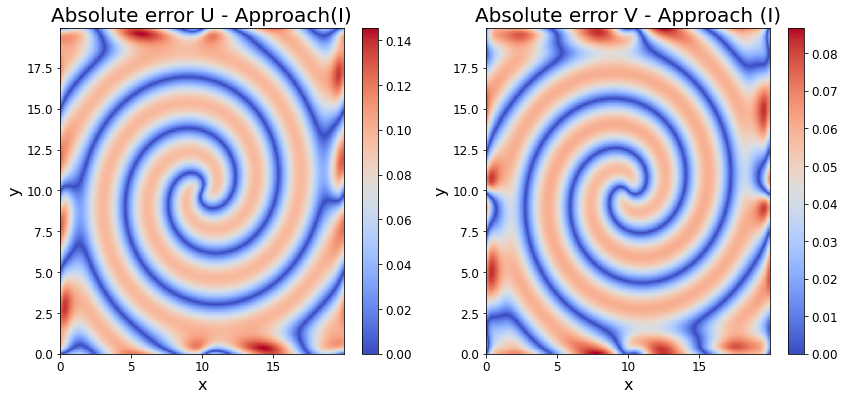

In [18]:
pylab.rcParams['figure.figsize'] = (14, 6)
figure()
xx, yy = meshgrid(
    np.arange(n)*dx,
    np.arange(n)*dy)
subplot(1,2,1)
im = pcolor(xx,yy,np.abs(U[:,:,t_test]-u_pred_full[:,:,t_test]),cmap='coolwarm')
colorbar(im)
title('Absolute error U - Approach(I)', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(1,2,2)
im = pcolor(xx,yy,np.abs(V[:,:,t_test]-v_pred_full[:,:,t_test]),cmap='coolwarm')
colorbar(im)
title('Absolute error V - Approach (I)', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (12, 8)

## Approach II (recursive): Advance solution from $t$ to $t + \Delta t$

In [19]:
np.random.seed(seed)

nn_flow = np.zeros((len(t), n_svd*2))
nn_flow[0, :] = nn_input[0,:]

for tt in range(len(t)-1):
    nn_flow[tt+1,:] = nn_model.predict(nn_flow[tt:tt+1,:])

In [20]:
nn_flow = scaler.inverse_transform(nn_flow)
print('mse: ', np.mean(np.square(nn_flow[1:,:] - nn_output)))

mse:  4089.666314094513


#### Reconstruct physical solution

In [21]:
u_pred_full = np.matmul(u_u_svd, np.transpose(nn_flow[:,:n_svd])).reshape(n,n,-1)
v_pred_full = np.matmul(v_u_svd, np.transpose(nn_flow[:,n_svd:])).reshape(n,n,-1)

C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/3037437474.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = pcolor(xx,yy,U[:,:,t_test],cmap='viridis', vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))
C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/3037437474.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = pcolor(xx,yy,u_pred_full[:,:,t_test],cmap='viridis',vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))
C:\Users\pao

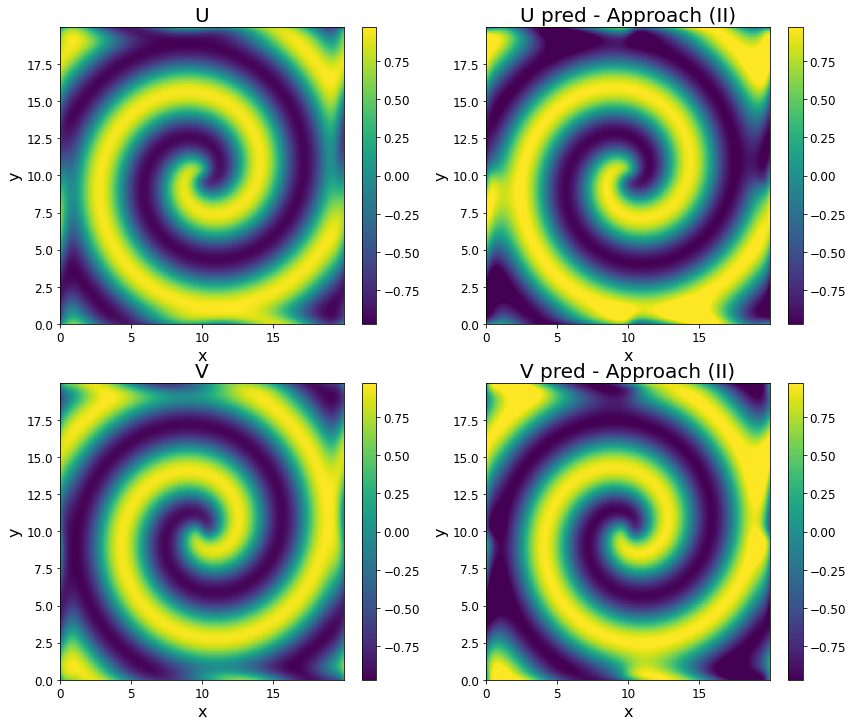

In [22]:
pylab.rcParams['figure.figsize'] = (14, 12)
figure()
xx, yy = meshgrid(
    np.arange(n)*dx,
    np.arange(n)*dy)
subplot(2,2,1)
im = pcolor(xx,yy,U[:,:,t_test],cmap='viridis', vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))
colorbar(im)
title('U', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(2,2,2)
im = pcolor(xx,yy,u_pred_full[:,:,t_test],cmap='viridis',vmin = np.min(U[:,:,t_test]), vmax = np.max(U[:,:,t_test]))
colorbar(im)
title('U pred - Approach (II)', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (14, 8)

subplot(2,2,3)
im = pcolor(xx,yy,V[:,:,t_test],cmap='viridis', vmin = np.min(V[:,:,t_test]), vmax = np.max(V[:,:,t_test]))
colorbar(im)
title('V', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
subplot(2,2,4)
im = pcolor(xx,yy,v_pred_full[:,:,t_test],cmap='viridis',vmin = np.min(V[:,:,t_test]), vmax = np.max(V[:,:,t_test]))
colorbar(im)
title('V pred - Approach (II)', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (14, 8)

#### Plot absolute error:

C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/815661663.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = pcolor(xx,yy,np.abs(U[:,:,t_test]-u_pred_full[:,:,t_test]),cmap='coolwarm')
C:\Users\paolo\AppData\Local\Temp/ipykernel_1516/815661663.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = pcolor(xx,yy,np.abs(V[:,:,t_test]-v_pred_full[:,:,t_test]),cmap='coolwarm')


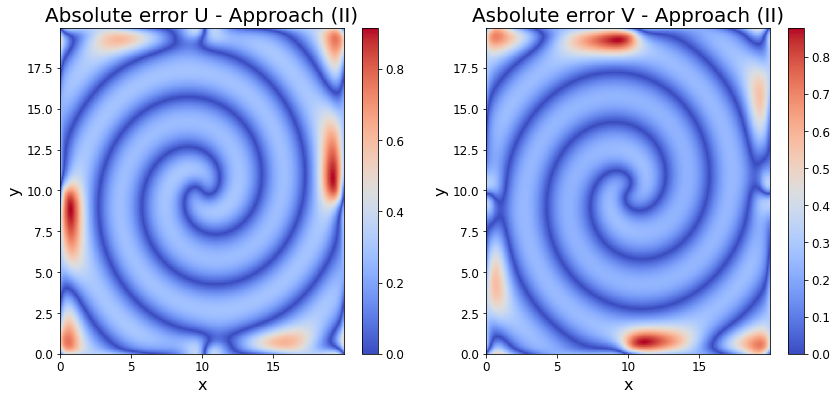

In [23]:
pylab.rcParams['figure.figsize'] = (14, 6)
figure()
xx, yy = meshgrid(
    np.arange(n)*dx,
    np.arange(n)*dy)
subplot(1,2,1)
im = pcolor(xx,yy,np.abs(U[:,:,t_test]-u_pred_full[:,:,t_test]),cmap='coolwarm')
title('Absolute error U - Approach (II)', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
colorbar(im)
subplot(1,2,2)
im = pcolor(xx,yy,np.abs(V[:,:,t_test]-v_pred_full[:,:,t_test]),cmap='coolwarm')
colorbar(im)
title('Asbolute error V - Approach (II)', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
pylab.rcParams['figure.figsize'] = (14, 8)